<a href="https://colab.research.google.com/github/GoogTech/langchain-tutorials/blob/master/LangGraph Glossary/LangGraph_Glossary.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Refer to the langgraph tutorials of `v0.2.74` : https://langchain-ai.github.io/langgraph/concepts/low_level/

# Installation

In [ ]:
!pip install -U langgraph langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.8 MB/s eta 0:00:00


In [ ]:
!pip show langgraph langchain_openai

Name: langgraph
Version: 0.2.74
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-sdk
Required-by: 
---
Name: langchain-openai
Version: 0.3.6
Summary: An integration package connecting OpenAI and LangChain
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: langchain-core, openai, tiktoken
Required-by: 


# 1.Graphs

In short:
* nodes do the work.
* edges tell what to do next.
* state represents the memory that records what you did.

## 1.1.StateGraph

## 1.2.Compiling your graph

In [ ]:
graph = graph_builder.compile(...)

# 2.State

## 2.1.Schema

### 2.1.1.How to use Pydantic model as graph state

https://langchain-ai.github.io/langgraph/how-tos/state-model/

A `StateGraph` accepts a state_schema argument on initialization `that` specifies the "shape" of the state `that` the nodes in the graph can access and update.

**Input Validation：**

In [ ]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel

# The overall state of the graph(this is the public state shared across nodes)
class OverallState(BaseModel):
  a: str

def node(state: OverallState):
  return {"a": "goodbye"}

# Build the state graph:
builder = StateGraph(OverallState)
builder.add_node('node', node)
builder.add_edge(START, 'node')
builder.add_edge('node', END)
graph = builder.compile()

# Test the graph with a valid input
graph.invoke({"a": "hello"})

{'a': 'goodbye'}

Invoke the graph with an invalid input

In [ ]:
try:
  graph.invoke({"a": 123})
except Exception as e:
    print("An exception was raised because `a` is an integer rather than a string.\n")
    print(e)

An exception was raised because `a` is an integer rather than a string.

1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


**Multiple Nodes：**

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel

# The overall state of the graph (this is the public state shared across nodes)
class OverallState(BaseModel):
    a: str

def bad_node(state: OverallState):
    return { # !!!returns an update to the state!!!
        "a": 123  # Invalid
    }

def ok_node(state: OverallState):
    return {"a": "goodbye"}

# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", "ok_node")
builder.add_edge("ok_node", END)
graph = builder.compile()

# Test the graph with a valid input
try:
    graph.invoke({"a": "hello"}) # !!!the validation error will occur when ok_node is called!!!
except Exception as e:
    print("An exception was raised because bad_node sets `a` to an integer.")
    print(e)

An exception was raised because bad_node sets `a` to an integer.
1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


### 2.1.2.How to define input/output schema for your graph

https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/

By default, StateGraph operates with a single schema, and all nodes are expected to communicate using that schema.

However, it's also possible to define distinct input and output schemas for a graph.

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

# Define the schema for the input.
# The input schema ensures that the provided input
# matches the expected structure.
class InputState(TypedDict):
    question: str

# Define the schema for the output.
# The output schema filters the internal data to return
# only the relevant information according to the defined output schema.
class OutputState(TypedDict):
    answer: str

# Define the overall schema, combining both input and output
class OverallState(InputState, OutputState):
    pass

# Define the node that processes the input and generates an answer
def node(state: OverallState):
    return {"question": state["question"], "answer": "This is answer..."}

# Build the graph with input and output schemas specified
builder = StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node(node)
builder.add_edge(START, "node")
builder.add_edge("node", END)
graph = builder.compile()

# Invoke the graph with and input and print the result.
# Notice that the output of invoke only includes the output schema.
print(graph.invoke({"question": "What is the meaning of life?"}))

{'answer': 'This is answer...'}


### Multiple schemas

we define an "internal" schema that contains all keys relevant to graph operations.

But, we also define input and output schemas that are sub-sets of the "internal" schema to constrain the input and output of the graph.

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

class InputState(TypedDict):
  user_input: str # shared with the schema of `OverallState`

class OutputState(TypedDict):
  graph_output: str # shared with the schema of `OverallState`

class OverallState(InputState, OutputState):
  foo: str
  user_input: str
  graph_output: str

class PrivateState(TypedDict):
  bar: str # private variable, because any one of schema doesn't include it.

#################################################################################################
# Sate Process: User ————> InputState ——> OverallState ——> PrivateSate ——> OutputState ——> User #
#################################################################################################
def node_1(state: InputState) -> OverallState:
  # Read from InputState, write to OverallState
  return {"foo": state["user_input"] + " name"}

def node_2(state: OverallState) -> PrivateState:
  # Read from OverallState, write to PrivateState
  return {"bar": state["foo"] + " is"}

def node_3(state: PrivateState) -> OutputState:
  # Read from PrivateState, write to OutputState
  return {"graph_output": state["bar"] + " Lance"}

builder = StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node(node_1)
builder.add_node(node_2)
builder.add_node(node_3)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

graph = builder.compile()
graph.invoke({"user_input": "My"})

{'graph_output': 'My name is Lance'}

#### How to pass private state between nodes

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

# The overall state of the graph(this is the public state shared across nodes)
class OverallState(TypedDict):
  a: str

# Output from node_1 contains private data that is not part of the overall state
class Node1Output(TypedDict):
  private_data: str

# Node 2 input onlu requests the private data available after node_1
class Node2Input(TypedDict):
  private_data: str

#################################################################################################################
# Sate Process: User ——> OverallState ——> Node1Output ~~~ Node2Input ——> OverallState ——> OverallState ——> User #
#################################################################################################################
# The private data is only shared between node_1 and node_2
def node_1(state: OverallState) -> Node1Output:
  output = {"private_data": "set by node_1"}
  print(f"Entered node `node_1`: \n\tInput: {state}.\n\tReturn:{output}")
  return output

def node_2(state: Node2Input) -> OverallState:
  output = {"a": "set by node_2"}
  print(f"Entered node `node_2`:\n\tInput: {state}.\n\tReturned: {output}")
  return output

# Node 3 only has access to the overall state (!!!no access to private data from node_1!!!)
def node_3(state: OverallState) -> OverallState:
  output = {"a": "set by node_3"}
  print(f"Entered node `node_3`:\n\tInput: {state}.\n\tReturned: {output}")
  return output

# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(node_1) # node_1 is the first node
builder.add_node(node_2) # node_2 is the second node and accepts private data from node_1
builder.add_node(node_3) # node_3 is the third node and does not see the private data
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

graph = builder.compile()

# Invoke the graph with the initial state
response = graph.invoke({"a": "hello"})
print(f"\nOutput of graph invocation: {response}")

Entered node `node_1`: 
	Input: {'a': 'hello'}.
	Return:{'private_data': 'set by node_1'}
Entered node `node_2`:
	Input: {'private_data': 'set by node_1'}.
	Returned: {'a': 'set by node_2'}
Entered node `node_3`:
	Input: {'a': 'set by node_2'}.
	Returned: {'a': 'set by node_3'}

Output of graph invocation: {'a': 'set by node_3'}


## 2.2.Reducers

Example A:

In [ ]:
from typing_extensions import TypedDict

class State(TypedDict):
    foo: int
    bar: list[str]

Example B:

In [ ]:
from typing import Annotated
from typing_extensions import  TypedDict
from operator import  add

class State(TypedDict):
    foo: int
    bar: Annotated[list[str], add]

## 2.3.Working with Messages in Graph State

### 2.3.1.Messages

LangChain provides a unified message format that can be used across all chat models, allowing users to work with different chat models without worrying about the specific details of the message format used by each model provider.

The five main message types are :

* SystemMessage: corresponds to `system` role
* HumanMessage: corresponds to `user` role
* AIMessage: corresponds to `assistant` role
* AIMessageChunk: corresponds to `assistant` role, used for `streaming` responses
* ToolMessage: corresponds to `tool` role

HumanMessage :

In [ ]:
from langchain_core.messages import HuamnMessage
model.invoke([HuamanMessage(content="hello, how are you?")])

# Or:
# When invoking a chat model with a string as input,
# LangChain will automatically convert the string into a HumanMessage object.
# This is mostly useful for quick testing.
model.invoke("hello, how are you?")

AIMessage :

In [ ]:
from langchain_core.messages import HumanMessage

ai_message = model.invoke([HumanMessage(content="Tell me a joke")])
ai_message # <-- AIMessage

AIMessageChunk :

In [ ]:
for chunk in model.stream([HuamnMessage("What color is the sky?")]):
  print(chunk)

OpenAI Format :
Chat models also accept OpenAI's format as inputs to chat models

In [ ]:
chat_model.invoke([
    {
      "role": "user",
      "content": "Hello, how are you?",
    },
    {
        "role": "assistant",
        "content": "I'm doing well, thank you for asking.",
    },
    {
        "role": "user",
        "content": "Can you tell me a joke?",
    }
])

### 2.3.2.Serialization

In [ ]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class State(TypedDict):
  # the state updates are always deserialized into LangChain Messages
  # when using add_messages
  messages: Annotated[list[AnyMessage], add_messages]

### 2.3.3.MessagesState

In [ ]:
from langgraph.graph import MessagesState

# MessagesState is defined with a single messages key
# which is a list of AnyMessage objects and uses the add_messages reducer.
class State(MessagesState):
  # Typically, there is more state to track than just messages,
  # so we see people subclass this state and add more fields, like:
  documents: list[str]

# 3.Nodes

In [ ]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph

builder = StateGraph(dict)https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node

# the first positional argument is the state,
# and (optionally), the second positional argument is a "config",
def my_node(state: dict, config: RunnableConfig):
  print("In node:", config["configurable"]["user_id"])
  return {"results": f"Hello, {state['input']}"}

# The second argument is optional
def my_other_node(state: dict):
  return state

builder.add_node('my_node', my_node)
# If you add a node to a graph without specifying a name,
# it will be given a default name equivalent to the function name.
builder.add_node(my_other_node)

### 3.1.START Node

In [ ]:
from langgraph.graph import START

#  The main purpose for referencing this node is
# to determine which nodes should be called first.
builder.add_edge(START, "my_node")

### 3.2.END Node

In [ ]:
from langgraph.graph import END

# This node is referenced when you want to denote
# which edges have no actions after they are done.
graph.add_edge("node_a", END)

# 4.Edges

### 4.1.Normal Edges


In [ ]:
graph.add_edge("node_a", "node_b")

### 4.2.Conditional Edges

In [ ]:
# By default, the return value routing_function is used as the name of the node (or list of nodes) to send the state to next.
# All those nodes will be run in parallel as a part of the next superstep.
graph.add_conditional_edges("node_a", routing_function)

# Or you can optionally provide a dictionary that maps the routing_function's output to the name of the next node.
graph.add_conditional_edges("node_a", routing_function, {True: "node_b", False: "node_a"})

# 5.Send

In [ ]:
def continue_to_jokes(state: OverallState):
  # Send takes two arguments:
  # first is the name of the node, and second is the state to pass to that node.
  return [Send("generate_joke", {"subject": s}) for s in state['subjects']]

graph.add_conditional_edges('node_a', continue_to_jokes)

# 6.Command

In [ ]:
#  you might want to BOTH perform state updates AND decide
# which node to go to next in the SAME node.
def my_node(state: State) -> Command[Literals["my_other_node"]]:
  return Command(
      # state udpate
      update = ("foo": "bar"),
      # control flow
      goto="my_other_node"
  )

# With `Command` you can also achieve dynamic control flow behavior (identical to conditional edges)
def my_node(state: State) -> Command[Literal["my_other_node"]]:
  if state["foo"] == "bar":
    return Command(
        update = {"foo": "baz"},
        goto = "my_other_node"
    )

## 6.1.When should I use Command instead of conditional edges?

Use Command when you need to both update the graph state and route to a different node.

For example, when implementing multi-agent handoffs where it's important to route to a different agent and pass some information to that agent.

## 6.2.Navigating to a node in a parent graph

In [ ]:
def my_node(state: State) -> Command[Literal['my_other_node']]:
  return Command(
      update = {"foo": "bar"},
      goto = "my_other_node", # # where `other_subgraph` is a node in the parent graph
      graph = Command.PARENT
  )

## 6.3.Using inside tools

In [ ]:
@tool
def lookup_user_info(tool_call_id: Annotated[str, InjectedToolCallId], config: RunnableConfig):
    """Use this to look up user information to better assist them with their questions."""
    user_info = get_user_info(config.get("configurable", {}).get("user_id"))
    return Command(
        update={
            # update the state keys
            "user_info": user_info,
            # update the message history
            "messages": [ToolMessage("Successfully looked up user information", tool_call_id=tool_call_id)]
        }
    )

## 6.4.Human-in-the-loop

### 6.4.1.Use cases

* 🛠️ Reviewing tool calls: Humans can review, edit, or approve tool calls requested by the LLM before tool execution.

* ✅ Validating LLM outputs: Humans can review, edit, or approve content generated by the LLM.

* 💡 Providing context: Enable the LLM to explicitly request human input for clarification or additional details or to support multi-turn conversations.

### 6.4.2.interrupt

In [ ]:
from typing import TypedDict
import uuid
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command

class State(TypedDict):
   """The graph state."""
   some_text: str

def human_node(state: State):
   value = interrupt(
      # Any JSON serializable value to surface to the human.
      # For example, a question or a piece of text or a set of keys in the state
      {
         "text_to_revise": state["some_text"]
      }
   )
   return {
      # Update the state with the human's input
      "some_text": value
   }

# Build the graph
graph_builder = StateGraph(State)
# Add the human-node to the graph
graph_builder.add_node("human_node", human_node)
graph_builder.add_edge(START, "human_node")

# A checkpointer is required for `interrupt` to work.
checkpointer = MemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

# Pass a thread ID to the graph to run it.
thread_config = {"configurable": {"thread_id": uuid.uuid4()}}

# Using stream() to directly surface the `__interrupt__` information.
for chunk in graph.stream({"some_text": "Original text"}, config=thread_config):
   print(chunk)

# Resume using Command
for chunk in graph.stream(Command(resume="Edited text"), config=thread_config):
   print(chunk)

{'__interrupt__': (Interrupt(value={'text_to_revise': 'Original text'}, resumable=True, ns=['human_node:e969b41f-65d8-65b5-43c0-9fec2ec4c437'], when='during'),)}
{'human_node': {'some_text': 'Edited text'}}


### 6.4.3.Requirements

To use interrupt in your graph, you need to:

1. Specify a `checkpointer` to save the graph state after each step.
2. Call `interrupt()` in the appropriate place. See the Design Patterns section for examples.
3. `Run the graph` with a `thread ID` until the interrupt is hit.
4. `Resume execution` using invoke/ainvoke/stream/astream

### 6.4.4.Desgin Patterns

#### 6.4.4.1.Approve or Reject

In [ ]:
from typing import Literal
from langgraph.types import interrupt, Command

def human_approval(state: State) -> Command[Literal["some_node", "another_node"]]:
    is_approved = interrupt(
        {
            "question": "Is this correct?",
            # Surface the output that should be
            # reviewed and approved by the human.
            "llm_output": state["llm_output"]
        }
    )
    if is_approved:
        return Command(goto="some_node")
    else:
        return Command(goto="another_node")

# Add the node to the graph in an appropriate location
# and connect it to the relevant nodes.
graph_builder.add_node("human_approval", human_approval)
graph = graph_builder.compile(checkpointer=checkpointer)

# After running the graph and hitting the interrupt, the graph will pause.
# Resume it with either an approval or rejection.
thread_config = {"configurable": {"thread_id": "some_id"}}
graph.invoke(Command(resume=True), config=thread_config)

#### 6.4.4.2.Review & Edit State


In [ ]:
from langgraph.types import interrupt

def human_editing(state: State):
    ...
    result = interrupt(
        # Interrupt information to surface to the client.
        # Can be any JSON serializable value.
        {
            "task": "Review the output from the LLM and make any necessary edits.",
            "llm_generated_summary": state["llm_generated_summary"]
        }
    )

    # Update the state with the edited text
    return {
        "llm_generated_summary": result["edited_text"]
    }

# Add the node to the graph in an appropriate location
# and connect it to the relevant nodes.
graph_builder.add_node("human_editing", human_editing)
graph = graph_builder.compile(checkpointer=checkpointer)

...

# After running the graph and hitting the interrupt, the graph will pause.
# Resume it with the edited text.
thread_config = {"configurable": {"thread_id": "some_id"}}
graph.invoke(
    Command(resume={"edited_text": "The edited text"}),
    config=thread_config
)

#### 6.4.4.3.Review Tool Calls

In [ ]:
def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    # This is the value we'll be providing via Command(resume=<human_review>)
    human_review = interrupt(
        {
            "question": "Is this correct?",
            # Surface tool calls for review
            "tool_call": tool_call
        }
    )
    review_action, review_data = human_review

    # Approve the tool call and continue
    if review_action == "continue":
        return Command(goto="run_tool")

    # Modify the tool call manually and then continue
    elif review_action == "update":
        ...
        updated_msg = get_updated_msg(review_data)
        # Remember that to modify an existing message you will need
        # to pass the message with a matching ID.
        return Command(goto="run_tool", update={"messages": [updated_message]})

    # Give natural language feedback, and then pass that back to the agent
    elif review_action == "feedback":
        ...
        feedback_msg = get_feedback_msg(review_data)
        return Command(goto="call_llm", update={"messages": [feedback_msg]})

#### 6.4.4.4.Multi-turn conversation

Using a human node per agent :

In [ ]:
from langgraph.types import interrupt

def human_input(state: State):
    human_message = interrupt("human_input")
    return {
        "messages": [
            {
                "role": "human",
                "content": human_message
            }
        ]
    }

def agent(state: State):
    # Agent logic
    ...

graph_builder.add_node("human_input", human_input)
graph_builder.add_edge("human_input", "agent")
graph = graph_builder.compile(checkpointer=checkpointer)

# After running the graph and hitting the interrupt, the graph will pause.
# Resume it with the human's input.
graph.invoke(
    Command(resume="hello!"),
    config=thread_config
)

Sharing human node across multiple agents :

In [ ]:
from langgraph.types import interrupt

def human_node(state: MessagesState) -> Command[Literal["agent_1", "agent_2", ...]]:
    """A node for collecting user input."""
    user_input = interrupt(value="Ready for user input.")

    # Determine the **active agent** from the state, so
    # we can route to the correct agent after collecting input.
    # For example, add a field to the state or use the last active agent.
    # or fill in `name` attribute of AI messages generated by the agents.
    active_agent = ...

    return Command(
        update={
            "messages": [{
                "role": "human",
                "content": user_input,
            }]
        },
        goto=active_agent,
    )

#### 6.4.4.5.Multi-turn conversation

In [ ]:
from langgraph.types import interrupt

def human_node(state: State):
    """Human node with validation."""
    question = "What is your age?"

    while True:
        answer = interrupt(question)

        # Validate answer, if the answer isn't valid ask for input again.
        if not isinstance(answer, int) or answer < 0:
            question = f"'{answer} is not a valid age. What is your age?"
            answer = None
            continue
        else:
            # If the answer is valid, we can proceed.
            break

    print(f"The human in the loop is {answer} years old.")
    return {
        "age": answer
    }

### 6.4.5.The Command primitive

1. Pass a value to the `interrput`:

In [ ]:
# Resume graph execution with the user's input.
graph.invoke(
    Command(resume={"age": "25"}),
    thread_config
)

2. Update the graph state:

In [ ]:
# Update the graph state and resume.
# You must provide a `resume` value if using an `interrupt`.
graph.invoke(
    Command(
        update={"age": "25"},
        resume="Let's go!!!",
    ),
    thread_config
)

### 6.4.6.Using with `invoke` and `ainvoke`

In [ ]:
# Run the graph up to the interrupt
result = graph.invoke(inputs, thread_config)

# Get the graph state to get interrupt information.
state = graph.get_state(thread_config)
# Print the state values
print(state.values)
# Print the pending tasks
print(state.tasks)

# Resume the graph with the user's input.
graph.invoke(Command(resume={"age": "25"}), thread_config)

In [ ]:
# {'foo': 'bar'} # State values
# (
#     PregelTask(
#         id='5d8ffc92-8011-0c9b-8b59-9d3545b7e553',
#         name='node_foo',
#         path=('__pregel_pull', 'node_foo'),
#         error=None,
#         interrupts=(Interrupt(value='value_in_interrupt', resumable=True, ns=['node_foo:5d8ffc92-8011-0c9b-8b59-9d3545b7e553'], when='during'),), state=None,
#         result=None
#     ),
# ) # Pending tasks. interrupts

### 6.4.7.How does resuming from an interrupt work?

In [ ]:
counter = 0
def node(state: State):
    # All the code from the beginning of the node to the interrupt will be re-executed
    # when the graph resumes.
    global counter
    counter += 1
    print(f"> Entered the node: {counter} # of times")
    # Pause the graph and wait for user input.
    answer = interrupt()
    print("The value of counter is:", counter)
    ...

In [ ]:
# > Entered the node: 2 # of times
# The value of counter is: 2

### 6.4.8.Common Pitfalls

#### 6.4.8.1.Side-effects

Side effects before interrupt(`BAD`) :

In [ ]:
from langchain.types import interrupt

def huamn_node(state: State):
  """Human node with validation"""
  api_call(...) # !!! This code will be re-executed when the node is resumed !!!
  answer = interrupt(question)

Side effects after interrupt(`OK`) :

In [ ]:
from langgraph.types import interrupt

def huamn_node(state: State):
  """Human node with validation"""
  answer = interrupt(question)
  api_call(...) # # OK as it's after the interrupt

Side effects in a separade node(`OK`) :



In [ ]:
from langgraph.types import interrupt

def huamn_node(state: State):
  """Human node with validation"""
  answer = interrupt(question)

def api_call_node(state: State):
  api_call(...) # OK as it's after the interrupt

#### 6.4.8.2.Subgraphs called as functions

In [ ]:
def node_in_parent_graph(state: State):
  some_code() # <-- This will re-execute when the subgraph is resumed.
  # Invoke a subgraph as a function.
  # The subgraph contains an `interrupt` call.
  subgraph_result = subgraph.invoke(some_result)
  ...

Here is abbreviated example code that you can use to understand how subgraphs work with interrupts. It counts the number of times each node is entered and prints the count.

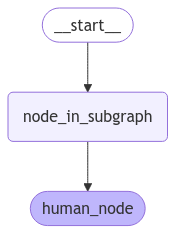

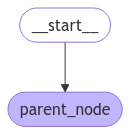


> (parent_node) Entered the node: 1 of times
> (node_in_subgraph) Entered the node: 1 of times
> (huamn_node) Entered the node: 1 of times
{'__interrupt__': (Interrupt(value='What is your name?', resumable=True, ns=['parent_node:e67ae280-4f8f-d72f-4640-73eea2c95533', 'human_node:31fa1255-dd5f-6265-0807-be5e01011328'], when='during'),)}

> (parent_node) Entered the node: 2 of times
> (huamn_node) Entered the node: 2 of times
Got an answer of 18
{'parent_node': {'some_text': 1}}


In [ ]:
import uuid
from typing import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command

class State(TypedDict):
   """The graph state."""
   some_text: str

counter_node_in_subgraph = 0
def node_in_subgraph(state: State):
   global counter_node_in_subgraph
   counter_node_in_subgraph += 1 # !!!This code will **NOT** run again!!!
   print(f"> (node_in_subgraph) Entered the node: {counter_node_in_subgraph} of times")

counter_huamn_node = 0
def human_node(state: State):
   global counter_huamn_node
   counter_huamn_node += 1 #!!!This code will run again!!!
   print(f"> (huamn_node) Entered the node: {counter_huamn_node} of times")
   answer = interrupt("What is your name?")
   print(f"Got an answer of {answer}")

subgraph_builder = StateGraph(State)
subgraph_builder.add_node("node_in_subgraph", node_in_subgraph)
subgraph_builder.add_node("human_node", human_node)
subgraph_builder.add_edge(START, "node_in_subgraph")
subgraph_builder.add_edge("node_in_subgraph", "human_node")
subgraph = subgraph_builder.compile(checkpointer=MemorySaver())

# ----------------------------------------------------------------------------------------------------

counter_parent_node = 0
def parent_node(state: State):
   """This parent node will invoke the subgraph"""
   global counter_parent_node
   counter_parent_node += 1 #!!!This code will run again on resuming!!!
   print(f"> (parent_node) Entered the node: {counter_parent_node} of times")
   # Invoke the subgraph
   subgraph_state = subgraph.invoke(state)
   return subgraph_state

graph_builder = StateGraph(State)
graph_builder.add_node("parent_node", parent_node)
graph_builder.add_edge(START, "parent_node")
graph = graph_builder.compile(checkpointer=MemorySaver()) # A checkpointer must be enabled for interrupts to work

# ----------------------------------------------------------------------------------------------------

from IPython.display import Image, display
display(Image(subgraph.get_graph().draw_mermaid_png()))
print()
display(Image(graph.get_graph().draw_mermaid_png()))
print()

# ----------------------------------------------------------------------------------------------------
config = {"configurable": {"thread_id": uuid.uuid4()}}
for chunk in graph.stream({"some_text": 1}, config):
  print(chunk)

print()
for chunk in graph.stream(Command(resume="18"), config):
  print(chunk)

#### 6.4.8.3.Using multiple interrupts

In [ ]:
import uuid
from typing import TypedDict, Optional

from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command

class State(TypedDict):
   """The graph state."""
   age: Optional[str]
   name: Optional[str]

def human_node(state: State):
  if not state.get('name'):
    name = interrupt("What is your name?")
  else:
    name = "N/A"

  if not state.get('age'):
    age = interrupt("What is your age?")
  else:
    age = "N/A"

  print(f"Name: {name}, Age: {age}")
  return {
    "name": name,
    "age": age
  }

graph_builder = StateGraph(State)
graph_builder.add_node("human_node", human_node)
graph_builder.add_edge(START, "human_node")
graph = graph_builder.compile(checkpointer=MemorySaver())

config = {"configurable": {"thread_id": uuid.uuid4()}}
for chunk in graph.stream({"age": None, "name": None}, config):
  print(chunk)

print()
for chunk in graph.stream(Command(resume="Hack", update={"name": "HackHuang"}), config):
  print(chunk)

{'__interrupt__': (Interrupt(value='What is your name?', resumable=True, ns=['human_node:51345894-6464-0ccd-3e87-ed2e24a374b5'], when='during'),)}

Name: N/A, Age: Hack
{'human_node': {'name': 'N/A', 'age': 'Hack'}}


# 7.Persistence

# 8.Threads

# 9.Storage

# 10.Graph Migrations

# 11.Configuration

# 12.interrupt

# 13.Breakpoints

# 14.Subgraphs

# 15.Visualization

# 16.Streaming